In [1]:
import os.path
import sys
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import ast
from keras.models import load_model
import scipy.io as scio
import random
from tqdm import tqdm

AES_Sbox = np.array([
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
])




Inv_SBox = np.array([
     0x52, 0x09, 0x6a, 0xd5, 0x30, 0x36, 0xa5, 0x38, 0xbf, 0x40, 0xa3,
     0x9e, 0x81, 0xf3, 0xd7, 0xfb, 0x7c, 0xe3, 0x39, 0x82, 0x9b, 0x2f,
     0xff, 0x87, 0x34, 0x8e, 0x43, 0x44, 0xc4, 0xde, 0xe9, 0xcb, 0x54,
     0x7b, 0x94, 0x32, 0xa6, 0xc2, 0x23, 0x3d, 0xee, 0x4c, 0x95, 0x0b,
     0x42, 0xfa, 0xc3, 0x4e, 0x08, 0x2e, 0xa1, 0x66, 0x28, 0xd9, 0x24,
     0xb2, 0x76, 0x5b, 0xa2, 0x49, 0x6d, 0x8b, 0xd1, 0x25, 0x72, 0xf8,
     0xf6, 0x64, 0x86, 0x68, 0x98, 0x16, 0xd4, 0xa4, 0x5c, 0xcc, 0x5d,
     0x65, 0xb6, 0x92, 0x6c, 0x70, 0x48, 0x50, 0xfd, 0xed, 0xb9, 0xda,
     0x5e, 0x15, 0x46, 0x57, 0xa7, 0x8d, 0x9d, 0x84, 0x90, 0xd8, 0xab,
     0x00, 0x8c, 0xbc, 0xd3, 0x0a, 0xf7, 0xe4, 0x58, 0x05, 0xb8, 0xb3,
     0x45, 0x06, 0xd0, 0x2c, 0x1e, 0x8f, 0xca, 0x3f, 0x0f, 0x02, 0xc1,
     0xaf, 0xbd, 0x03, 0x01, 0x13, 0x8a, 0x6b, 0x3a, 0x91, 0x11, 0x41,
     0x4f, 0x67, 0xdc, 0xea, 0x97, 0xf2, 0xcf, 0xce, 0xf0, 0xb4, 0xe6,
     0x73, 0x96, 0xac, 0x74, 0x22, 0xe7, 0xad, 0x35, 0x85, 0xe2, 0xf9,
     0x37, 0xe8, 0x1c, 0x75, 0xdf, 0x6e, 0x47, 0xf1, 0x1a, 0x71, 0x1d,
     0x29, 0xc5, 0x89, 0x6f, 0xb7, 0x62, 0x0e, 0xaa, 0x18, 0xbe, 0x1b,
     0xfc, 0x56, 0x3e, 0x4b, 0xc6, 0xd2, 0x79, 0x20, 0x9a, 0xdb, 0xc0,
     0xfe, 0x78, 0xcd, 0x5a, 0xf4, 0x1f, 0xdd, 0xa8, 0x33, 0x88, 0x07,
     0xc7, 0x31, 0xb1, 0x12, 0x10, 0x59, 0x27, 0x80, 0xec, 0x5f, 0x60,
     0x51, 0x7f, 0xa9, 0x19, 0xb5, 0x4a, 0x0d, 0x2d, 0xe5, 0x7a, 0x9f,
     0x93, 0xc9, 0x9c, 0xef, 0xa0, 0xe0, 0x3b, 0x4d, 0xae, 0x2a, 0xf5,
     0xb0, 0xc8, 0xeb, 0xbb, 0x3c, 0x83, 0x53, 0x99, 0x61, 0x17, 0x2b,
     0x04, 0x7e, 0xba, 0x77, 0xd6, 0x26, 0xe1, 0x69, 0x14, 0x63, 0x55,
     0x21, 0x0c, 0x7d])


Using TensorFlow backend.


In [2]:
def load_sca_model(model_file):
    try:
        model = tf.keras.models.load_model(model_file)
    except:
        print("Error: can't load Keras model file '%s'" % model_file)
        sys.exit(-1)
    return model


In [3]:
def get_prediction(model, Traces):
    # Get the input layer shape
    input_layer_shape = model.get_layer(index=0).input_shape

    # Sanity check
    if input_layer_shape[1] != len(Traces[0]):
        print("Error: model input shape %d instead of %d is not expected ..." % (
            input_layer_shape[1], len(Traces[0])))
        sys.exit(-1)

    # Adapt the data shape according our model input
    if len(input_layer_shape) == 2:
        # This is a MLP
        input_data = Traces
    elif len(input_layer_shape) == 3:
        # This is a CNN: reshape the data
        input_data = Traces
        input_data = input_data.reshape((input_data.shape[0], input_data.shape[1], 1))
    else:
        print("Error: model input shape length %d is not expected ..." % len(input_layer_shape))
        sys.exit(-1)

    # Predict our probabilities
    predictions = model.predict(input_data)

    return predictions

In [4]:
def prediction_to_probability(selected_Pts_interest, selected_predictions, NUMBER):
    probabilities_array = []

    for i in range(NUMBER):

        probabilities = np.zeros(256)

        for j in range(256):
            #value = AES_Sbox[selected_Pts_interest[i] ^ j]
            
            firstround_sboxin= selected_Pts_interest[i]^j
            firstround_sboxout= AES_Sbox[firstround_sboxin]  
    
            value = firstround_sboxout
            #value = SBox_in^SBox_out
            
            
            #value = selected_Pts_interest[i] ^ j
            #value = Inv_Sbox[selected_Pts_interest[i] ^ j]			
			
            probabilities[j] = selected_predictions[i][value]

        # print(probabilities)

        probabilities_array.append(probabilities)

        # print(probabilities_array)

    probabilities_array = np.array(probabilities_array)


    for i in range(len(probabilities_array)):
        if np.count_nonzero(probabilities_array[i]) != 256:
            none_zero_predictions = [a for a in probabilities_array[i] if a != 0]

            min_v = min(none_zero_predictions)

            probabilities_array[i] = probabilities_array[i] + min_v**2	

    return probabilities_array

In [5]:
def rank_cal(selected_probabilities, key_interest, NUMBER):
    rank = []

    total_pro = np.zeros(256)

    for i in range(NUMBER):
        # epsilon = 4*10**-12

        # selected_probabilities[i] = selected_probabilities[i] +epsilon

        total_pro = total_pro + np.log(selected_probabilities[i])

        # find the rank of real key in the total probabilities

        sorted_proba = np.array(list(map(lambda a: total_pro[a], total_pro.argsort()[::-1])))

        real_key_rank = np.where(sorted_proba == total_pro[key_interest])[0][0]

        rank.append(real_key_rank)

    rank = np.array(rank)

    return rank

In [66]:
def test(model_path):
    
    number_total_trace = 5000
    # load traces
    Traces = np.load('D10/1_avg/nor_traces_maxmin.npy')
    #Traces = np.load('ashes_trace/15m/5k_device10_15m/1avg/nor_traces_maxmin.npy')
    Traces = Traces[:, [i for i in range(126,236)]]               # 2nd sbox interval version for the first round
    #Traces = Traces[:, [i for i in range(130,240)]]              # 1st sbox interval version for the first round
    #Traces = Traces[:,[i for i in range(56,166)]]    #the 110 points related to the add-key operation (first round)
    Traces = Traces[:number_total_trace]

    # load key
    key = np.load('D10/1_avg/key.npy')
    #key = np.load('ashes_trace/15m/5k_device10_15m/1avg/key.npy')
    # load plaintext (all bytes)
    Pts = np.load('D10/1_avg/pt.npy')
    #Pts = np.load('ashes_trace/15m/5k_device10_15m/1avg/pt.npy')
    Pts = Pts[:number_total_trace]




    # choose interest key byte and pt byte
    interest_byte = 0
    key_interest = key[interest_byte]
    Pts_interest = Pts[:, interest_byte]


    model = load_sca_model(model_path)

    # get predictions for all traces
    predictions = get_prediction(model, Traces)

    # randomly select trace for testing

    NUMBER = 4800


    average = 30

    ranks_array = []


    for i in range(average):
        select = random.sample(range(len(Traces)), NUMBER)

        selected_Pts_interest = Pts_interest[select]
        selected_predictions = predictions[select]

        # calculate subkey probability for selected traces
        probabilities = prediction_to_probability(selected_Pts_interest, selected_predictions, NUMBER)

        ranks = rank_cal(probabilities, key_interest, NUMBER)

        ranks_array.append(ranks)

    ranks_array = np.array(ranks_array)

	
    for i in range(ranks_array.shape[1]):

        if np.count_nonzero(ranks_array[:, i]) < int(average / 2):
		
            print(i)
            break
	
	
    average_ranks = np.sum(ranks_array, axis=0) / average

    print(np.min(average_ranks))
    plt.plot(average_ranks)
    plt.show()









  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

cnn_model-23.h5
110.73333333333333


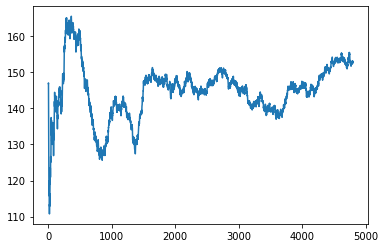









 12%|██████████▌                                                                         | 1/8 [00:53<06:14, 53.44s/it]

cnn_model-24.h5
14.966666666666667


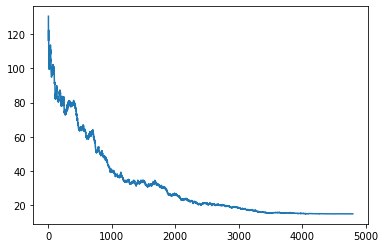









 25%|█████████████████████                                                               | 2/8 [01:46<05:20, 53.35s/it]

cnn_model-25.h5
13.966666666666667


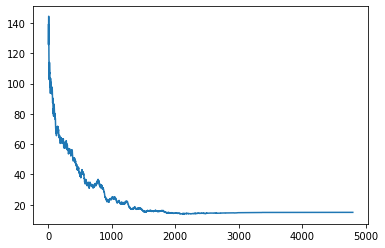









 38%|███████████████████████████████▌                                                    | 3/8 [02:39<04:26, 53.32s/it]

cnn_model-26.h5
13.8


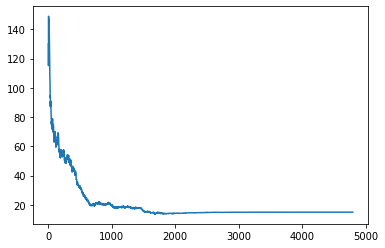









 50%|██████████████████████████████████████████                                          | 4/8 [03:32<03:32, 53.12s/it]

cnn_model-34.h5
5.1


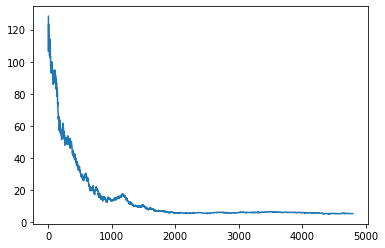









 62%|████████████████████████████████████████████████████▌                               | 5/8 [04:25<02:39, 53.01s/it]

cnn_model-35.h5
4.7


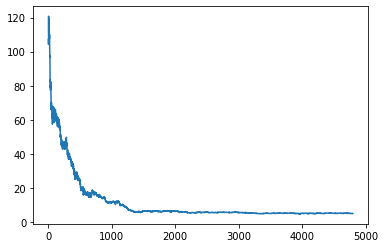









 75%|███████████████████████████████████████████████████████████████                     | 6/8 [05:17<01:45, 52.93s/it]

cnn_model-37.h5
4.266666666666667


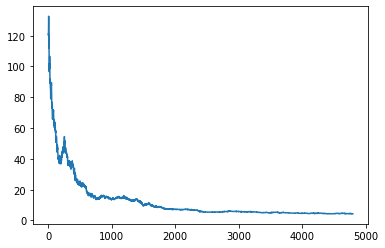









 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [06:11<00:52, 52.97s/it]

cnn_model-38.h5
8.3


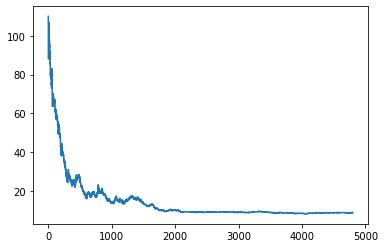









100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [07:04<00:00, 53.08s/it]


In [67]:
if __name__ == "__main__":


 
    # model path
    models_folder = 'model/test'
    files= os.listdir(models_folder)
    
    for file in tqdm(files):
        print(file)
        modelname = models_folder+'/'+file
        test(modelname)

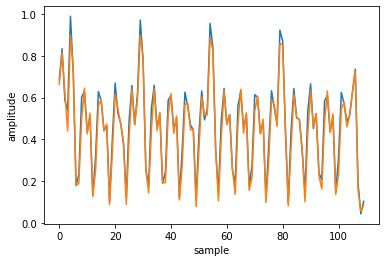

In [25]:
Traces = np.load('ashes_trace/15m/5k_device7_15m/100avg/nor_traces_maxmin.npy')
Traces = Traces[:, [i for i in range(126,236)]] 

Traces2 = np.load('train_trace/nor_traces_maxmin.npy')
Traces2 = Traces2[:, [i for i in range(126,236)]] 
plt.plot(Traces[1,:])
plt.plot(Traces2[1,:])
plt.xlabel('sample')
plt.ylabel('amplitude')
plt.savefig('train_vs_test.png',dpi=500)

In [9]:
key = np.load('D6/100_avg/key.npy')
key

array([ 48, 241,  72, 104, 164,  50,  86, 193,  77, 208,  35,  18, 189,
       128,   0, 183])

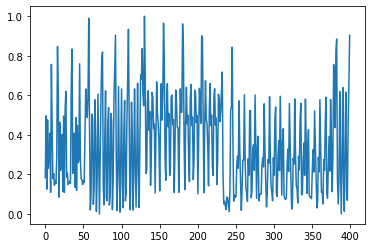

In [20]:
Traces = np.load('D6/100_avg/nor_traces_maxmin.npy')
#Traces = Traces[:, [i for i in range(130,240)]] 

plt.plot(Traces[1,:])